In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle

Notas: A nossa solução inicial assumia que era possível fazer o tracing das bicicletas, mas após ser fornecido o dicionário, percebemos que tal não era possível dado que "The same bike can have multiple tags over the year".

In [2]:
base = '/home/ana/Downloads/'

In [3]:
def get_loans_clean(base):

    df = pd.read_pickle(base + 'df_clean')[["Id_Historico_Prestamo", "Id_Usuario", "Id_Tag_Bicicleta", \
            "Fecha_Prestamo", "Fecha_Devolucion", "Id_Aparcamiento_Origen", "Posicion_Origen", \
            "Id_Aparcamiento_Destino", "Posicion_Destino"]]
    
    # Rename columns
    # The same bike can have multiple tags over the year.
    df = df.rename(columns={
        "Id_Historico_Prestamo": "Loan ID",
        "Id_Usuario": "User ID",
        "Id_Tag_Bicicleta": "Tag ID",
        "Fecha_Prestamo": "Start loan",
        "Fecha_Devolucion": "End loan",
        "Id_Aparcamiento_Origen": "ID start station",
        "Posicion_Origen": "Position start",
        "Id_Aparcamiento_Destino": "ID end station",
        "Posicion_Destino": "Position end"
    })
    
    return df

df = get_loans_clean(base)
df

,Loan ID,User ID,Tag ID,Start loan,End loan,ID start station,Position start,ID end station,Position end
0,6501462,18701,1164,2017-06-21 14:22:11.000,2017-06-21 14:38:29.000,8,1,43.0,1.0
1,6501318,41811,1089,2017-06-21 14:07:18.000,2017-06-21 14:39:06.000,56,6,54.0,NaN
2,6501489,96620,1110,2017-06-21 14:25:11.000,2017-06-21 14:39:07.000,36,25,9.0,13.0
3,6501001,16055,1465,2017-06-21 13:35:52.000,2017-06-21 14:39:22.000,8,1,9.0,6.0
4,6501421,6431,996,2017-06-21 14:17:56.000,2017-06-21 14:39:26.000,56,14,54.0,NaN
...,...,...,...,...,...,...,...,...,...
10387747,14454800,27944,2369,2019-12-31 13:58:55.000,2019-12-31 14:25:38.000,40,1,50.0,1.0
10387748,14454778,108800,2393,2019-12-31 13:52:48.000,2019-12-31 14:40:52.000,28,1,50.0,1.0
10387749,14454793,98449,60,2019-12-31 13:55:47.000,2019-12-31 14:41:39.000,113,1,28.0,1.0
10387750,14454774,129665,1829,2019-12-31 13:51:28.000,2019-12-31 16:27:12.000,39,15,41.0,15.0


Stations information

In [5]:
df_info = pd.read_csv("station_location_with_id.csv", sep=';')[['ID','numSlots','isManual']]
df_info.head()

,ID,numSlots,isManual
0,1,15,1
1,2,33,1
2,3,40,0
3,4,10,1
4,5,33,1


Loans per minute

In [6]:
def get_loans_or_devolutions_per_station_per_5_minutes(_df, field_date, field_station, field_position):
    df = _df.copy()
    df = df[[field_date, field_station, field_position]]
    df[field_position] = [1]*len(df.index)
    df[field_date] = pd.to_datetime(df[field_date], format='%Y-%m-%d %H:%M:%S.%f')
    df[field_date] = df[field_date].dt.round("1H")
    df = df.rename(columns={field_date:'Date', field_station:'Station'})
    df = df.groupby(['Station', 'Date']).count()
    
    if(field_date=='Start loan'):
        df = df.rename(columns={field_position:'N Loans'})
    else:
        df = df.rename(columns={field_position:'N Devolutions'})
        
    return df

def get_loans_and_devolutions_info(_df):
    loans = get_loans_or_devolutions_per_station_per_5_minutes(_df, \
                    'Start loan', 'ID start station', 'Position start')
    
    devolutions = get_loans_or_devolutions_per_station_per_5_minutes(_df, \
                    'End loan', 'ID end station', 'Position end')
    
    df = pd.concat([loans, devolutions], axis=1)
    df = df.fillna(0)
    
    return df

loans_and_devolutions = get_loans_and_devolutions_info(df)
loans_and_devolutions.head(5)

N Loans  N Devolutions
Station Date                                       
0.0     2017-10-03 22:00:00      0.0            1.0
        2018-03-21 11:00:00      0.0            1.0
        2018-03-21 18:00:00      0.0            1.0
1.0     2016-01-04 06:00:00      5.0            1.0
        2016-01-04 07:00:00     11.0            2.0

In [7]:
def get_balance_for_station(_df, station):
    df = _df.copy()
    df = df.reset_index()
    df = df.loc[df['Station']==station]
    df['N Loans cumsum'] = df['N Loans'].cumsum() # perdem bicicletas
    df['N Devolutions cumsum'] = df['N Devolutions'].cumsum() # ganham bicicletas
    df['Balance'] = df['N Devolutions cumsum'] - df['N Loans cumsum'] # balanço total
    
    return df

<AxesSubplot:xlabel='Date'>

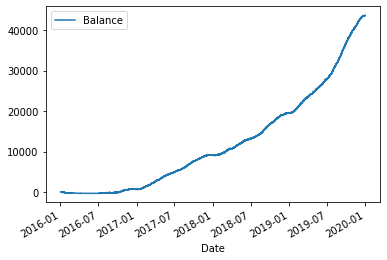

In [22]:
balance_st_1 = get_balance_for_station(loans_and_devolutions, 1)
balance_st_1.plot(x='Date', y='Balance')

<AxesSubplot:xlabel='Date'>

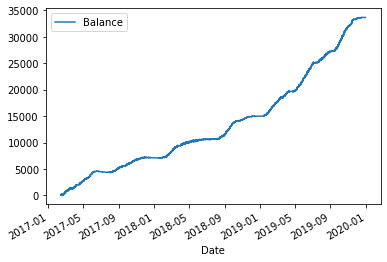

In [9]:
balance_st_70 = get_balance_for_station(loans_and_devolutions, 70)
balance_st_70.plot(x='Date', y='Balance')

<AxesSubplot:xlabel='Date'>

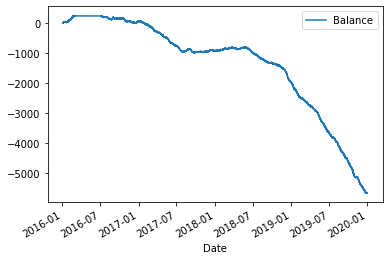

In [10]:
balance_st_21 = get_balance_for_station(loans_and_devolutions, 21)
balance_st_21.plot(x='Date', y='Balance')

<AxesSubplot:xlabel='Date'>

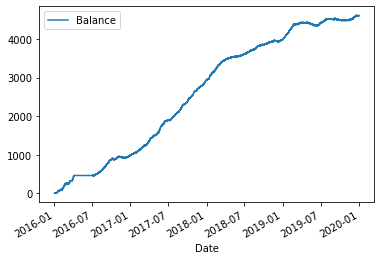

In [11]:
balance_st_45 = get_balance_for_station(loans_and_devolutions, 45)
balance_st_45.plot(x='Date', y='Balance')

In [12]:
balance_st_45['Balance'].min()

1.0

In [14]:
loans_and_devolutions.head(10)

N Loans  N Devolutions
Station Date                                       
0.0     2017-10-03 22:00:00      0.0            1.0
        2018-03-21 11:00:00      0.0            1.0
        2018-03-21 18:00:00      0.0            1.0
1.0     2016-01-04 06:00:00      5.0            1.0
        2016-01-04 07:00:00     11.0            2.0
        2016-01-04 08:00:00     10.0            1.0
        2016-01-04 09:00:00      6.0            1.0
        2016-01-04 10:00:00      3.0            3.0
        2016-01-04 11:00:00      4.0            5.0
        2016-01-04 12:00:00      4.0            2.0

In [15]:
loans_and_devolutions.tail(50)

N Loans  N Devolutions
Station Date                                       
118.0   2019-12-26 18:00:00      5.0            2.0
        2019-12-26 19:00:00      3.0            4.0
        2019-12-26 20:00:00      2.0            3.0
        2019-12-27 06:00:00      1.0            0.0
        2019-12-27 07:00:00      2.0            0.0
        2019-12-27 08:00:00      5.0            2.0
        2019-12-27 09:00:00      1.0            0.0
        2019-12-27 10:00:00      3.0            0.0
        2019-12-27 12:00:00      0.0            1.0
        2019-12-27 13:00:00      1.0            1.0
        2019-12-27 14:00:00      1.0            0.0
        2019-12-27 16:00:00      1.0            0.0
        2019-12-27 17:00:00      0.0            1.0
        2019-12-27 18:00:00      1.0            0.0
        2019-12-27 19:00:00      2.0            1.0
        2019-12-27 21:00:00      0.0            1.0
        2019-12-28 07:00:00      4.0            2.0
        2019-12-28 08:00:00      1.0            1.0
        2019-12-28 09:00:00      1.0            0.0
        2019-12-28 10:00:00      0.0            1.0
        2019-12-28 11:00:00      3.0            1.0
        2019-12-28 12:00:00      2.0            1.0
        2019-12-28 13:00:00      3.0            0.0
        2019-12-28 14:00:00      2.0            0.0
        2019-12-28 15:00:00      6.0            4.0
        2019-12-28 16:00:00      2.0            1.0
        2019-12-28 17:00:00      1.0            0.0
        2019-12-28 18:00:00      3.0            2.0
        2019-12-30 06:00:00      1.0            0.0
        2019-12-30 07:00:00      2.0            1.0
        2019-12-30 08:00:00      2.0            1.0
        2019-12-30 09:00:00      1.0            1.0
        2019-12-30 10:00:00      2.0            0.0
        2019-12-30 11:00:00      2.0            1.0
        2019-12-30 13:00:00      1.0            0.0
        2019-12-30 14:00:00      4.0            3.0
        2019-12-30 15:00:00      3.0            2.0
        2019-12-30 16:00:00      1.0            1.0
        2019-12-30 17:00:00      3.0            0.0
        2019-12-30 18:00:00      1.0            2.0
        2019-12-30 19:00:00      1.0            2.0
        2019-12-31 06:00:00      1.0            0.0
        2019-12-31 07:00:00      3.0            2.0
        2019-12-31 12:00:00      0.0            1.0
        2019-12-31 13:00:00      2.0            2.0
        2019-12-31 15:00:00      0.0            1.0
120.0   2019-12-04 18:00:00      0.0            1.0
        2019-12-09 18:00:00      0.0            1.0
        2019-12-09 19:00:00      0.0            1.0
        2019-12-28 22:00:00      0.0            1.0

In [19]:
#def plot_balance(loans_and_devolutions):
#    balance_df = loans_and_devolutions.copy()
#    balance_df = balance_df.reset_index()
#    balance_df = balance_df.loc[balance_df["Station"]==8]
#    balance_df = balance_df[["Date", "Balance"]]
#    balance_df['Balance'].plot()
    
## corrigir - timesteps em falta
#plot_balance(loans_and_devolutions)

Obter o número inicial de bicicletas por estação

In [20]:
# ver o primeiro mês em que a estação abre, e fazer a contagens por aí

def get_init_number_of_bikes_per_station(_df):
    df = _df.copy()
    df = df[["Tag ID", "Start loan", "ID start station"]]
    df["Start loan"] = pd.to_datetime(df["Start loan"], format='%Y-%m-%d %H:%M:%S.%f')
    df = df.sort_values(by="Start loan")
    # for each tag get first station
    df = df.groupby("Tag ID").first() \
            .reset_index() \
            [["Tag ID", "ID start station"]]
    # for each station get initial number of bikes 
    df = df.groupby("ID start station").count()
    return df
    
init_n_bikes = get_init_number_of_bikes_per_station(df)
init_n_bikes.tail()

,Tag ID
ID start station,
112,17
113,7
114,25
115,6
118,18


In [21]:
init_n_bikes.head(50)

,Tag ID
ID start station,
1,212
2,47
3,36
4,12
5,35
6,69
7,130
8,314
9,416


Loans per station per minute

Verificar quando as estações automáticas cheias. -> ver para cada estação qual o nº máximo de posições diferentes e depois tentar perceber qnd é que elas estão cheias (elas estão cheias se num dado intervalo de tempo todas as positions estão ocupadas) ---> taxa de ocupação

Há posições que nunca são ocupadas!!!!

In [ ]:
def occupation_tax(nPos, maxPos):
    return (nPos*100)/maxPos

In [ ]:
# obter  a posição inicial da bicicleta de forma a saber quantas bicicletas tem cada estação inicialmente
'''
def get_bike_first_location(_df, station):

    df = _df.copy()
    df = df[['Id_Tag_Bicicleta', 'Fecha_Prestamo', 'Fecha_Devolucion', 'Id_Aparcamiento_Origen', \
             'Posicion_Origen', 'Id_Aparcamiento_Destino', 'Posicion_Destino']]
    
    df = df[(df['Id_Aparcamiento_Origen']==station) | (df['Id_Aparcamiento_Destino']==station)]
    #df_ts = df_ts.set_index(['Fecha_Prestamo', 'month'])

    return df

# eles podem ter bicicletas na estação q nós não sabemos porque nunca são emprestadas!!!!!!!!!!!!!!!!!!!!!!!!!
get_bikes_per_station(df, 8)
'''


In [ ]:
df.columns

Ver a taxa de ocupação a cada hora

Ver a capacidade de armazenamento das estações automáticas. Quais são as estações automáticas com maior capacidade de armazenamento? Quais as com menor?